<a href="https://colab.research.google.com/github/Georgitanev/google_big_query/blob/main/google_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Table and graphics from Google Analytics public dataset**




In [42]:
import os
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt


json_path = "/content/big-query-284408-e895d0eb5b23.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=json_path

client = bigquery.Client()         # Start the BigQuery Client
# Input your Query Syntax here; You may try it first at https://console.cloud.google.com/bigquery
sql = """SELECT *
              FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
              LIMIT 1"""

# I am using low limits, because I have some limits in Google Big Query
df = client.query(sql).to_dataframe()
df.head()

# Explore data

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,None,1,1501583974,1501583974,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Car...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2248281639583218707,None,None,Organic Search,Not Socially Engaged


In [43]:
%%bigquery 
# this gives option to run BigQuery statements directly in Jupyter

SELECT distinct(channelGrouping)
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
LIMIT 10

,channelGrouping
0,Organic Search
1,Direct
2,Referral
3,Paid Search
4,Display
5,Affiliates
6,Social


Date,	channel,	visits,	transactions,	transaction revenue

In [44]:
# query by BigQuery Google Analytics tutorial
sql = """SELECT
                    date,
                    channelGrouping as channel,
                    totals.visits,
                    totals.transactions,
                    totals.transactionRevenue
                    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
                    LIMIT 5"""

def get_data(sql):
  df = client.query(sql).to_dataframe()
  df['date'] = pd.to_datetime(df.date).dt.strftime('%Y-%m--%d')
  return df

df = get_data(sql)
df.head()

,date,channel,visits,transactions,transactionRevenue
0,2017-08--01,Organic Search,1,None,None
1,2017-08--01,Organic Search,1,None,None
2,2017-08--01,Organic Search,1,None,None
3,2017-08--01,Direct,1,None,None
4,2017-08--01,Organic Search,1,None,None


Select date, channel, visits, transactions and transaction revenue - first 100 results

Direct visitors and organic search data: ordered by transaction revenue


In [45]:
sql ="""SELECT
                      date,
                      channelGrouping as channel,
                      totals.visits,
                      totals.transactions,
                      totals.transactionRevenue
                      FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
                      WHERE channelGrouping in ('Direct', 'Organic Search')
                      ORDER BY totals.transactionRevenue desc LIMIT 5"""

df = get_data(sql)
df.head()

,date,channel,visits,transactions,transactionRevenue
0,2017-08--01,Direct,1,1,1000780000
1,2017-08--01,Direct,1,1,982730000
2,2017-08--01,Organic Search,1,1,400210000
3,2017-08--01,Direct,1,1,347140000
4,2017-08--01,Organic Search,1,1,169900000


Aggregate transaction totals

In [46]:
# query by BigQuery Google Analytics tutorial
query_organic_direct = """SELECT date, channelGrouping as channel,
                                          sum(totals.visits) as visits, 
                                          CASE WHEN sum(totals.visits) > 0 THEN sum(totals.transactions) / sum(totals.visits) 
                                          ELSE 0 END as conv_rate, 
                                          sum(totals.transactions) as transactions, 
                                          CASE WHEN sum(totals.transactions) > 0 THEN
                                          sum(totals.transactionRevenue) / sum(totals.transactions)
                                          ELSE 0 END as aov,
                                          sum(totals.transactionRevenue) as revenue 
                                          FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
                                          WHERE channelGrouping in ('Organic Search', 'Direct') 
                                          GROUP BY date, channel
                                          ORDER BY transactions 
                                          desc LIMIT 1000"""

df = get_data(sql)
df.head()

,date,channel,visits,transactions,transactionRevenue
0,2017-08--01,Direct,1,1,1000780000
1,2017-08--01,Direct,1,1,982730000
2,2017-08--01,Organic Search,1,1,400210000
3,2017-08--01,Direct,1,1,347140000
4,2017-08--01,Organic Search,1,1,169900000


**all channels**


Number of visitors per date, by channel - Organic Search and Paid Search

In [47]:
sql = """SELECT distinct(date), channelGrouping as channel, count(totals.visits) as visitors_num, 
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE channelGrouping like '%Search'
GROUP BY date, channel
ORDER BY date
LIMIT 20 """

df = get_data(sql)
df.head()



,date,channel,visitors_num
0,2016-08--01,Organic Search,362
1,2016-08--01,Paid Search,25
2,2016-08--02,Paid Search,48
3,2016-08--02,Organic Search,663
4,2016-08--03,Organic Search,903


Number of visitors by date (paid/ organic search) in different color schemas

Text(0.5, 1.0, 'Visitors per day from Search channels')

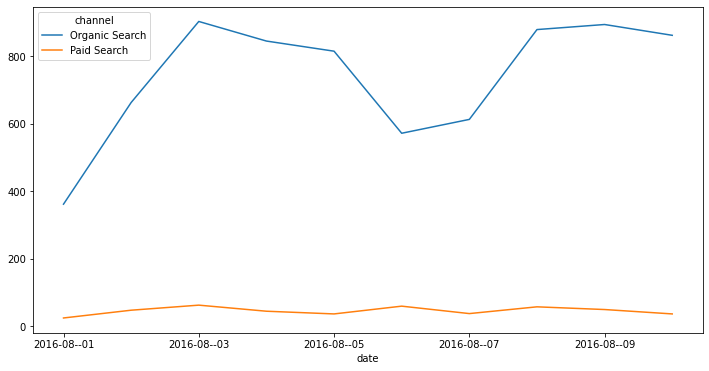

In [48]:
df_line = df
df_plot = df_line.pivot('date', 'channel', 'visitors_num')
df_plot.plot(figsize=(12, 6));
fig = plt.Figure()
ax = fig.add_subplot()
ax.set_title('Visitors per day from Search channels')

Paid search and Organic search

Text(0, 0.5, 'Visitors')

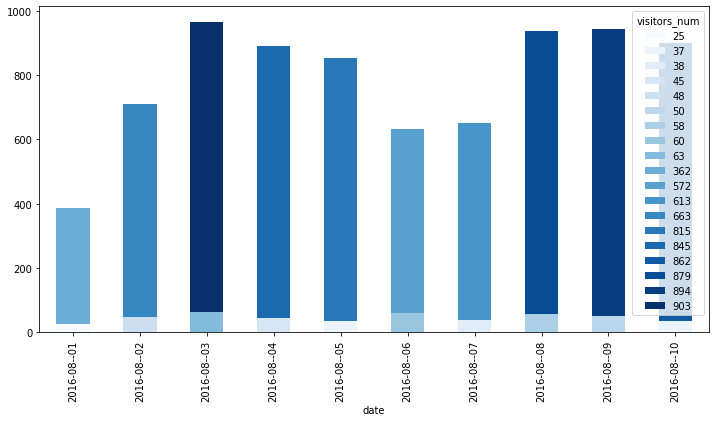

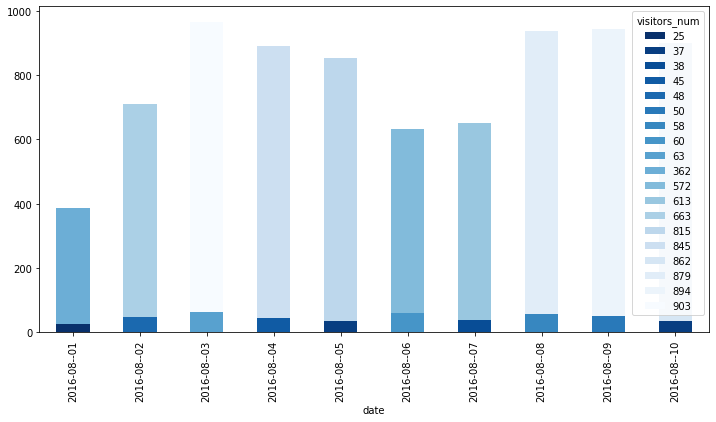

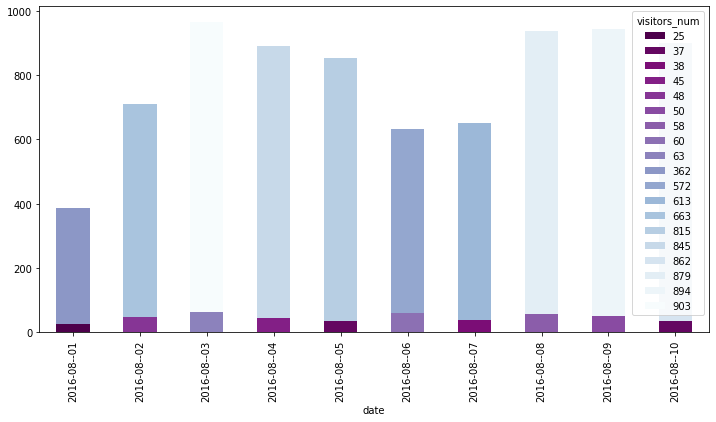

In [49]:
pivot_table = df.pivot(index="date", columns="visitors_num", values="visitors_num")
bar_list = [ 'Blues', 'Blues_r', 'BuPu_r'] # list of styles for graphics
for n, i in enumerate(bar_list):
  pivot_table.plot(kind="bar", stacked=True, colormap=bar_list[n], figsize=(12,6))
ax.set_title("Visitors per day from Search channels")
ax.set_xlabel("Date")
ax.set_ylabel("Visitors")

Visitors per day from All channels


In [50]:
sql = """SELECT distinct(date), count(totals.visits) as visitors_num, 
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY date
ORDER BY date
LIMIT 20 """

df_all_visitors = get_data(sql)
df_all_visitors.head()

,date,visitors_num
0,2016-08--01,1711
1,2016-08--02,2140
2,2016-08--03,2890
3,2016-08--04,3161
4,2016-08--05,2702


Bar chart - Number of visitors per day in different colors

Text(0, 0.5, 'Visitors')

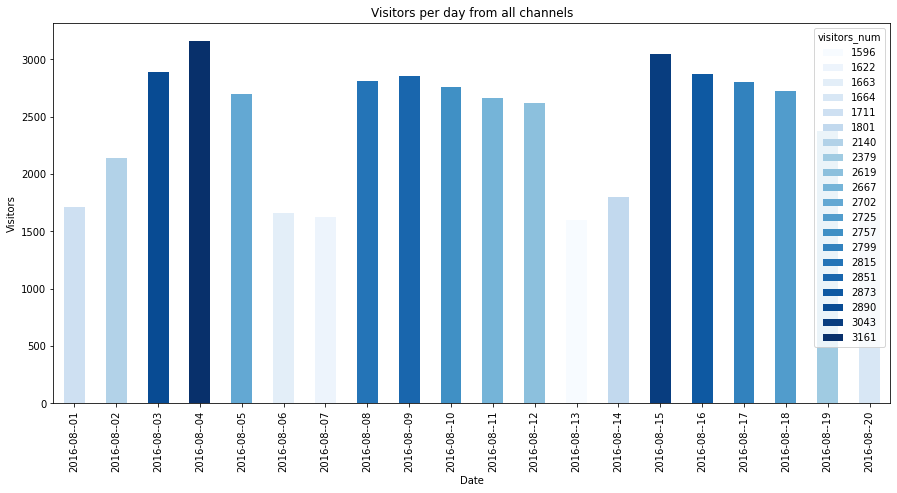

In [51]:
pivot_table = df_all_visitors.pivot(index="date", columns="visitors_num", values="visitors_num")
ax = pivot_table.plot(kind="bar", stacked=True, colormap =  'Blues', figsize=(15, 7))
ax.set_title("Visitors per day from all channels")
ax.set_xlabel("Date")
ax.set_ylabel("Visitors")